#### Libraries & reading

In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("autosavetime/main")
utils.load_extension("execute_time/ExecuteTime")

<IPython.core.display.Javascript object>

In [34]:
import pandas as pd
pd.set_option('display.max_columns', 500)
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from cern_utils import plot_feature_importance
from sklearn.metrics import roc_auc_score,auc
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
plt.style.use('seaborn')

import math

import random 
random.seed(0)

from path_utils import return_impurity,pie_plot_filtered

In [35]:
train = pd.read_csv("train.csv", index_col="Id")
test = pd.read_csv("test.csv", index_col="Id")
train = train.drop(columns="BUTTER")
test = test.drop(columns="BUTTER")

## Feature Engineering

In [36]:
train['train']=1
test['train']=0


In [37]:
df = train.append(test)

In [38]:
df.columns = df.columns.str.replace(' ', '')

In [39]:
df.head()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA,signal,train
Id,,,,,,,,,,,,,,,,
0,28.878847,2.662533,2924.690991,0.999997,19085.568945,0.569198,-0.575502,0.581565,66850.893711,0.637969,14298.486178,7940.694301,2.628526,2.680116,1.0,1
1,34.233566,0.092746,346.948714,0.999997,6631.244546,0.248707,-0.615941,0.277898,39274.475071,0.148815,11553.163934,3904.681337,3.292504,3.085754,1.0,1
2,36.113632,2.442423,238.553023,0.999986,7740.918989,0.222347,0.249383,0.216576,27757.153899,0.249840,24081.196003,4738.891687,3.433676,3.121906,1.0,1
3,14.286133,6.337556,227.375132,0.999806,6740.281614,0.347316,0.591884,0.306927,10593.207077,0.400748,11343.521945,3308.943750,2.291867,2.200712,0.0,1
4,60.474274,7.632751,106.730650,0.999905,5556.388794,0.204273,0.655850,0.196600,11801.249543,0.223101,25940.693317,4026.326871,3.290073,3.281829,0.0,1


In [40]:
df['random'] = np.random.random(df.shape[0])

### Features

In [41]:
df['total_mom_2'] = df['B_PT']**2 + df['gamma_PT']**2 + df['Kplus_P']**2
df['total_mom_sum'] = df['B_PT'] + df['gamma_PT']+ df['Kplus_P']

In [42]:
# All mom ratios worked together
df["mom_rat_1"] = df["B_PT"] / df["Kplus_P"]
df["mom_rat_2"] = df["B_PT"] / df["gamma_PT"]


df["mom_rat_3"] = df["gamma_PT"] / df["B_PT"]
df["mom_rat_4"] = df["gamma_PT"] / df["Kplus_P"]

df["mom_rat_5"] = df["Kplus_P"] / df["B_PT"]
df["mom_rat_6"] = df["Kplus_P"] / df["gamma_PT"]

In [43]:
df['ThetaH'] = np.arccos(df['Kst_892_0_cosThetaH'])


df['Kplus_P_x'] = df['Kplus_P'] * np.sin(df['ThetaH'])
df['Kplus_P_y'] = df['Kplus_P'] * np.cos(df['ThetaH'])

In [44]:
df['mom_consev1'] = df["gamma_PT"]**2 + df["Kplus_P"]**2 - df["B_PT"]**2
df['mom_consev1_1'] = ((df["gamma_PT"] + df["Kplus_P"]))**2 - df["B_PT"]**2

## Splits

In [45]:
train = df[df['train']==1].drop(columns='train')
test = df[df['train']==0].drop(columns='train')

In [46]:
X_tr, X_te, y_tr, y_te = train_test_split(
    train.drop(columns="signal"),
    train.signal,
    stratify=train.signal,
    random_state=0,  # train_size=0.99
)

## Catboost

In [47]:
cb = CatBoostClassifier(verbose=0, eval_metric="AUC", iterations=200,
                        random_seed=0)
cb.fit(X_tr, y_tr)

In [48]:
print("train", roc_auc_score(y_tr.values,cb.predict_proba(X_tr)[:,1]))
print("test", roc_auc_score( y_te,cb.predict_proba(X_te)[:,1]))

train 0.8959177211822856
test 0.8704447635522761


26 features, reduction of 0.00%


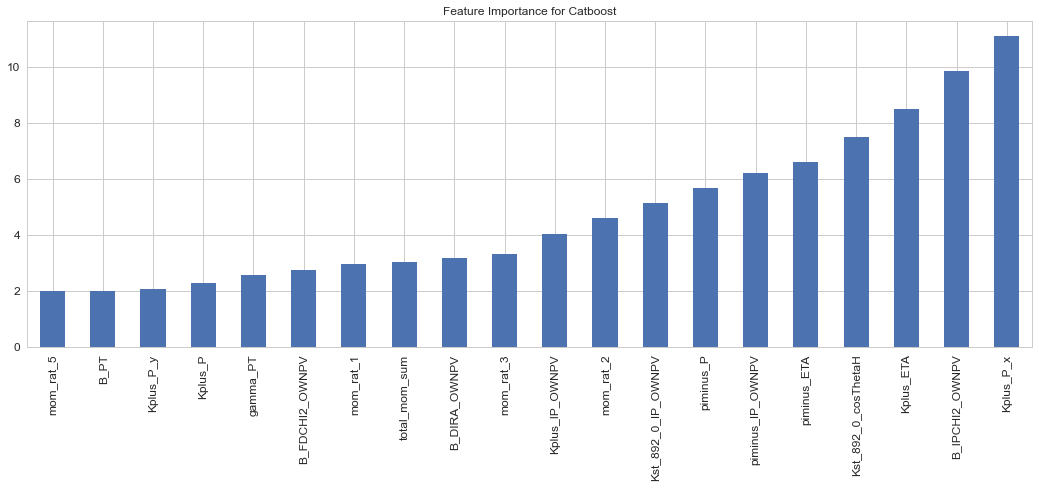

In [19]:
plot_feature_importance(X_tr.columns,cb.get_feature_importance(),columns_ploted=20)

## Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

In [21]:
dt = DecisionTreeClassifier()
dt.fit(X_tr,y_tr)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [22]:
return_impurity(dt, X_tr[X_tr.index == random.choice(X_tr.index)])

,feature,impurity,samples,imp_child,samples_child,impurity_gain,samples_gain
0,Kst_892_0_cosThetaH,0.444889,159496.0,0.480466,121606.0,7.856306,0.237561
1,Kst_892_0_IP_OWNPV,0.480466,121606.0,0.416789,63589.0,20.015783,0.363752
2,B_IPCHI2_OWNPV,0.416789,63589.0,0.471754,36667.0,5.771556,0.168794
3,mom_rat_3,0.471754,36667.0,0.429363,25456.0,3.992542,0.070290
4,B_FDCHI2_OWNPV,0.429363,25456.0,0.342925,9365.0,4.839228,0.100887
5,B_OWNPV_CHI2,0.342925,9365.0,0.276359,5960.0,0.980835,0.021348
6,B_FDCHI2_OWNPV,0.276359,5960.0,0.337409,3146.0,0.367163,0.017643
7,B_IPCHI2_OWNPV,0.337409,3146.0,0.265269,1531.0,0.410895,0.010126
8,mom_rat_3,0.265269,1531.0,0.203441,844.0,0.146977,0.004307
9,Kst_892_0_cosThetaH,0.203441,844.0,0.225352,734.0,0.003947,0.000690


In [23]:
res_g = (
    return_impurity(dt, X_tr[X_tr.index == random.choice(X_tr.index)])
    .groupby("feature", as_index=False)
    .sum()
)
res_g.sort_values('samples_gain',ascending=False)

,feature,impurity,samples,imp_child,samples_child,impurity_gain,samples_gain
6,Kst_892_0_IP_OWNPV,0.930255,122985.0,0.974543,58998.0,18.561321,0.401182
1,B_IPCHI2_OWNPV,1.446648,63610.0,1.076973,23798.0,13.043283,0.249611
7,Kst_892_0_cosThetaH,0.444889,159496.0,0.480466,121606.0,7.856306,0.237561
11,piminus_IP_OWNPV,0.452857,19996.0,0.496575,5558.0,3.947031,0.090523
5,Kplus_P_x,0.957039,3038.0,0.949450,1802.0,0.381010,0.007662
8,ThetaH,0.499672,3787.0,0.494344,3084.0,0.230539,0.004408
10,piminus_ETA,0.611039,2861.0,0.472421,2160.0,0.233798,0.004395
2,Kplus_ETA,0.499662,423.0,0.472778,180.0,0.079160,0.001524
4,Kplus_P,0.491295,2986.0,0.486595,2846.0,0.051510,0.000878
12,random,0.461950,174.0,0.499822,53.0,0.033787,0.000759


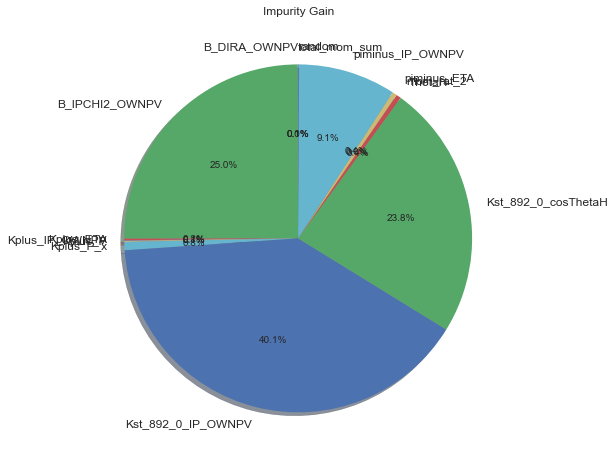

In [24]:

pie_plot_filtered(res_g, "samples_gain", title="Impurity Gain")

## Submission